In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [2]:
#! pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

Import data

In [4]:
df = pd.read_csv('Aquifer_Auser.csv')

<Axes: xlabel='date'>

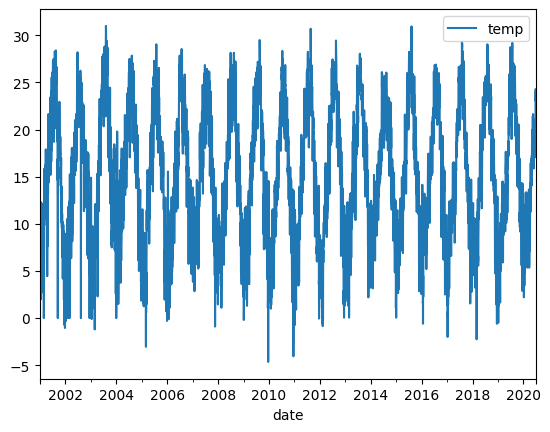

In [5]:
df.rename(columns={'Temperature_Orentano':'temp'},inplace=True)
df =df[1035:]
df = df.loc[:,df.columns.isin(['temp', 'Date'])].copy()
df['date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df.set_index('date', inplace=True)
df.drop(columns = ['Date'], inplace = True)
df.plot()

# Checking for stationarity: ADH (Augented Dicky Fuller Test

In [6]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['temp'], autolag = 'AIC')

print('1. ADF : ',dftest[0])
print('2. P-Value : ',dftest[1]) # low p-value means time series is stationary
print('3. Number of Lags : ',dftest[2])
print('4. Number of observations used for ADF Regression and Critical val Creation : ',dftest[3])
print('5. Critical Values : ')
for key, val in dftest[4].items():
  print('\t', key, ": ", val)





1. ADF :  -5.211212656549626
2. P-Value :  8.340296394873222e-06
3. Number of Lags :  29
4. Number of observations used for ADF Regression and Critical val Creation :  7089
5. Critical Values : 
	 1% :  -3.431272791574912
	 5% :  -2.8619478005445225
	 10% :  -2.566987068168671


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


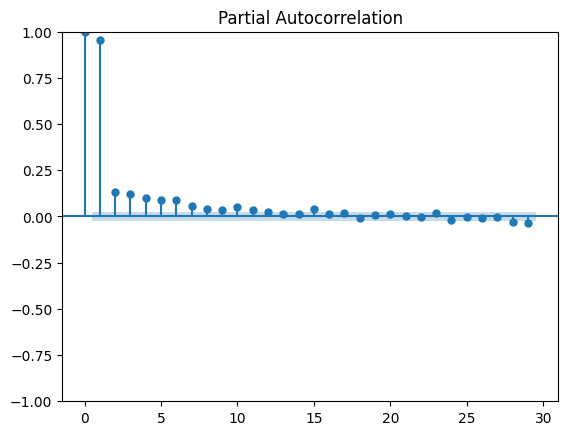

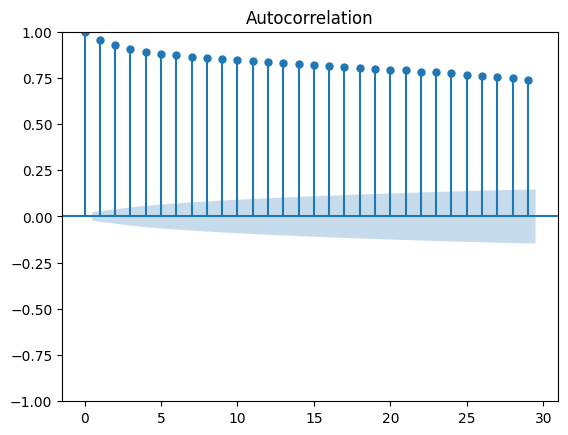

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
pacf = plot_pacf(df['temp'], lags = 29)
acf = plot_acf(df['temp'], lags = 29)
# for auto regression we use the PACF, as it only has the direct effects. 

Split data into training and testing set for the last seven days

In [8]:
train = df[:len(df)-7]
test = df[len(df)-7:]

In [9]:
model = AutoReg(train, lags = 3). fit() # 7 time lags with significant corr values

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [10]:
print(model.summary())
# p value shows how important or significant each time lag is for the prediction. The lower the p value the 
# more significant the time lag is fo rthe prediction. This can eb tuned to certain time lags. 

                            AutoReg Model Results                             
Dep. Variable:                   temp   No. Observations:                 7112
Model:                     AutoReg(3)   Log Likelihood              -15088.723
Method:               Conditional MLE   S.D. of innovations              2.021
Date:                Mon, 10 Apr 2023   AIC                          30187.445
Time:                        15:01:44   BIC                          30221.791
Sample:                    01-06-2001   HQIC                         30199.271
                         - 06-23-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5025      0.057      8.739      0.000       0.390       0.615
temp.L1        0.8148      0.012     69.252      0.000       0.792       0.838
temp.L2        0.0288      0.015      1.893      0.0

# Make predictions

In [11]:
pred = model.predict(start = len(train), end = len(df)-1, dynamic = False)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


(array([18437., 18438., 18439., 18440., 18441., 18442., 18443.]),
 [Text(18437.0, 0, '2020-06-24'),
  Text(18438.0, 0, '2020-06-25'),
  Text(18439.0, 0, '2020-06-26'),
  Text(18440.0, 0, '2020-06-27'),
  Text(18441.0, 0, '2020-06-28'),
  Text(18442.0, 0, '2020-06-29'),
  Text(18443.0, 0, '2020-06-30')])

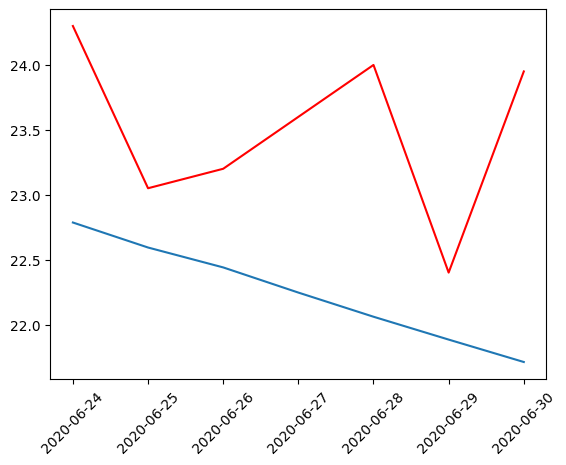

In [12]:
plt.plot(pred)
plt.plot(test, color = 'red')
plt.xticks(rotation=45)

In [13]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, pred))
print(rmse)

1.4119369000012907


# Trying for future predictions

In [14]:
pred_future = model.predict(start = len(df)+1, end = len(df)+7, dynamic=False)
print("The future prediction for next week: ")
print(pred_future)
print("number of predictions made : \t", len(pred_future))

The future prediction for next week: 
2020-07-02    21.378066
2020-07-03    21.218108
2020-07-04    21.062239
2020-07-05    20.910388
2020-07-06    20.762452
2020-07-07    20.618327
2020-07-08    20.477914
Freq: D, dtype: float64
number of predictions made : 	 7


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


# ARIMA!!!

From [here](https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53)

In [15]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00


In [25]:
df = pd.read_csv('MaunaLoaDailyTemps.csv', index_col = 'DATE', parse_dates = True)
#df.index = pd.DatetimeIndex(df.index).to_period('d')
df = df.dropna()
print(df.shape)
df.head()

(1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


<Axes: xlabel='DATE'>

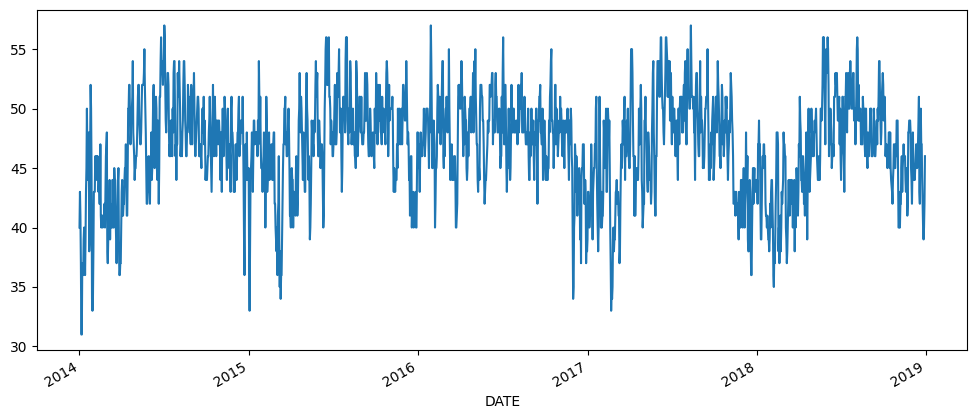

In [26]:
df['AvgTemp'].plot(figsize=(12,5))


# Stationarity Check

In [27]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",  dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['AvgTemp'])

1. ADF :  -6.554680125068777
2. P-Value :  8.675937480199653e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


To interpret the test results, you only need to look at the p value. And you use the following simple method:


1.   If p< 0.05 ; Data is stationary

2.   if p>0.05; Data is not stationary

It’s not a hard and fast rule, but a stationary data should have a small p value. Larger p value could indicate presence of certain trends(varying mean) or seasonality as well.

# Dimentioning the ARIMA Model

In [28]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['AvgTemp'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8344.735, Time=3.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10347.755, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8365.701, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9136.225, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19192.139, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8355.947, Time=2.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8356.308, Time=2.71 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8347.311, Time=6.17 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8318.337, Time=3.73 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8330.192, Time=3.55 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8310.577, Time=8.46 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=8332.293, Time=4.53 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=8317.620, Time=5.86 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=8306.228, Time=6.65 sec
 ARIMA(1,0,4)(0,0,0)[0] interce

# Implementing Arima

## Train test split

In [30]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(1821, 5)
(1791, 5) (30, 5)


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1791 entries, 2014-01-01 to 2018-11-30
Freq: D
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MinTemp  1791 non-null   float64
 1   MaxTemp  1791 non-null   float64
 2   AvgTemp  1791 non-null   float64
 3   Sunrise  1791 non-null   int64  
 4   Sunset   1791 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 84.0 KB


In [45]:
print (train.index.inferred_freq)

None


In [50]:
train.index = pd.DatetimeIndex(train.index).to_period('D')

In [52]:
print (train.index.freq)

<Day>


In [76]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['AvgTemp'],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Mon, 10 Apr 2023   AIC                           8156.395
Time:                        15:46:10   BIC                           8200.320
Sample:                    01-01-2014   HQIC                          8172.614
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Check the model performance

DATE
2018-12-01    44.754109
2018-12-02    44.987795
2018-12-03    45.388741
2018-12-04    45.721545
2018-12-05    45.863733
2018-12-06    45.874126
2018-12-07    45.884370
2018-12-08    45.894466
2018-12-09    45.904417
2018-12-10    45.914225
2018-12-11    45.923891
2018-12-12    45.933418
2018-12-13    45.942808
2018-12-14    45.952063
2018-12-15    45.961185
2018-12-16    45.970175
2018-12-17    45.979036
2018-12-18    45.987769
2018-12-19    45.996377
2018-12-20    46.004861
2018-12-21    46.013222
2018-12-22    46.021463
2018-12-23    46.029586
2018-12-24    46.037591
2018-12-25    46.045481
2018-12-26    46.053258
2018-12-27    46.060923
2018-12-28    46.068477
2018-12-29    46.075922
2018-12-30    46.083261
Name: ARIMA Predictions, dtype: float64


(array([17866., 17870., 17874., 17878., 17882., 17886., 17890., 17894.]),
 [Text(17866.0, 0, '2018-12-01'),
  Text(17870.0, 0, '2018-12-05'),
  Text(17874.0, 0, '2018-12-09'),
  Text(17878.0, 0, '2018-12-13'),
  Text(17882.0, 0, '2018-12-17'),
  Text(17886.0, 0, '2018-12-21'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17894.0, 0, '2018-12-29')])

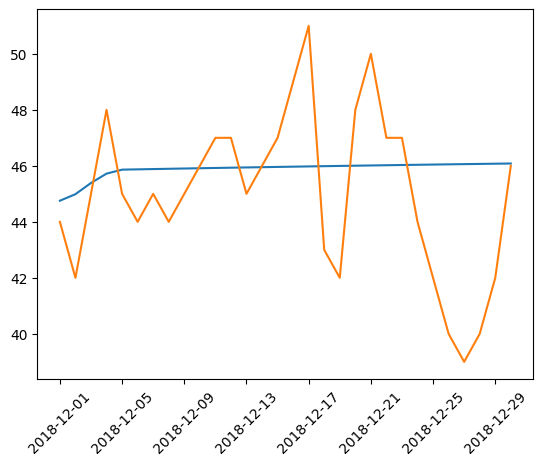

In [77]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.index = df.index[start:end+1]

print(pred)

fig, ax = plt.subplots()
ax.plot( pred.index , pred)
ax.plot(test['AvgTemp'])
plt.xticks(rotation=45)

In [143]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['AvgTemp'].mean()
rmse=sqrt(mean_squared_error(pred,test['AvgTemp']))
print(rmse)

3.000463825206671
